# Illuminant Data Augmentation Pipeline

This notebook performs:
1. **Clustering**: Groups images by illuminant chromaticity (similar to `illuminant_eda.ipynb`)
2. **Analysis**: Identifies cluster imbalances
3. **Augmentation**: Creates augmented images to balance cluster sizes
4. **Organization**: Saves images to cluster-named folders

## Workflow:
- Load Nikon_D810 dataset (.wp files)
- Perform K-Means clustering on RGB chromaticity
- Map each image to its cluster
- Determine augmentation needs per cluster
- Apply augmentation (cropping with resize, rotation, etc.)
- Save to `augmented_dataset/` organized by cluster names


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Dec  7 20:54:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import glob
import os
from PIL import Image
import shutil
import warnings
import random
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Imports complete")
print(f"Random seed set to {RANDOM_SEED} for reproducibility")


Imports complete
Random seed set to 42 for reproducibility


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 149.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5f972ad5df1dfc3e969a9e3e6aa9baf5cce1e43fd37774565baa98854482a2cf
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# ============================================================
# 1. CONFIG & DEVICE
# ============================================================
DATA_ROOT = "/content/drive/MyDrive/illuminantClassification/dataset"
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
NUM_WORKERS = 8
IMG_SIZE = 224
NUM_CLASSES = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# ============================================================
# 2. DATA LOADING
# ============================================================
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Class names from folder structure
label_names = train_dataset.classes
print(f"Classes: {label_names}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Classes: ['Cool', 'Neutral', 'Very_Cool', 'Very_Warm', 'Warm']
Train: 5400, Val: 1540, Test: 780


In [ ]:
class IllumiCam3(nn.Module):
    def __init__(self, num_classes=5):
        super(IllumiCam3, self).__init__()

        # Conv Block 1: Conv(32, 10x10) -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Block 2: Conv(64, 7x7) -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Block 3: Conv(96, 5x5) -> BN -> ReLU
        self.conv3 = nn.Conv2d(64, 96, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(96)

        # Conv Block 4: Conv(128, 5x5) -> BN -> ReLU
        self.conv4 = nn.Conv2d(96, 128, kernel_size=5)
        self.bn4 = nn.BatchNorm2d(128)

        # Conv Block 5: Conv(256, 3x3) -> BN -> ReLU
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(256)

        # Global Average Pooling (changed from Max)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected (unchanged)
        self.fc1 = nn.Linear(256, 1024)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Block 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Block 3
        x = self.relu(self.bn3(self.conv3(x)))

        # Block 4
        x = self.relu(self.bn4(self.conv4(x)))

        # Block 5
        x = self.relu(self.bn5(self.conv5(x)))

        # Global pooling + FC
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model = IllumiCam3(num_classes=NUM_CLASSES).to(device)
print(model)

IllumiCam3(
  (conv1): Conv2d(3, 32, kernel_size=(10, 10), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): L

In [ ]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 1,135,685
Trainable parameters: 1,135,685


In [ ]:
# ============================================================
# 4. LOSS, OPTIMIZER, SCHEDULER
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=4,
    min_lr=5e-12
)


TRAINING


Epoch [1/20] Train Loss: 1.2463, Train Acc: 0.5257 | Val Loss: 1.3445, Val Acc: 0.3604
  -> Saved best model (val_acc: 0.3604)


Epoch [2/20] Train Loss: 0.9129, Train Acc: 0.6380 | Val Loss: 1.2117, Val Acc: 0.4727
  -> Saved best model (val_acc: 0.4727)


Epoch [3/20] Train Loss: 0.8158, Train Acc: 0.6663 | Val Loss: 1.4039, Val Acc: 0.3896


Epoch [4/20] Train Loss: 0.7593, Train Acc: 0.6998 | Val Loss: 1.3058, Val Acc: 0.5078
  -> Saved best model (val_acc: 0.5078)


Epoch [5/20] Train Loss: 0.7163, Train Acc: 0.7126 | Val Loss: 0.9104, Val Acc: 0.5851
  -> Saved best model (val_acc: 0.5851)


Epoch [6/20] Train Loss: 0.6837, Train Acc: 0.7274 | Val Loss: 1.3749, Val Acc: 0.4481


Epoch [7/20] Train Loss: 0.6679, Train Acc: 0.7370 | Val Loss: 1.2291, Val Acc: 0.5669


Epoch [8/20] Train Loss: 0.6243, Train Acc: 0.7537 | Val Loss: 1.0641, Val Acc: 0.5403


Epoch [9/20] Train Loss: 0.6011, Train Acc: 0.7643 | Val Loss: 0.7524, Val Acc: 0.6825
  -> Saved best model (val_acc: 0.6825)


Epoch [10/20] Train Loss: 0.6085, Train Acc: 0.7557 | Val Loss: 1.0817, Val Acc: 0.5597


Epoch [11/20] Train Loss: 0.5891, Train Acc: 0.7719 | Val Loss: 1.8706, Val Acc: 0.3961


Epoch [12/20] Train Loss: 0.5733, Train Acc: 0.7713 | Val Loss: 1.0724, Val Acc: 0.5110


Epoch [13/20] Train Loss: 0.5695, Train Acc: 0.7781 | Val Loss: 1.1601, Val Acc: 0.5299


Epoch [14/20] Train Loss: 0.5475, Train Acc: 0.7848 | Val Loss: 1.3575, Val Acc: 0.5396


Epoch [15/20] Train Loss: 0.5129, Train Acc: 0.8085 | Val Loss: 0.6363, Val Acc: 0.7519
  -> Saved best model (val_acc: 0.7519)


Epoch [16/20] Train Loss: 0.4943, Train Acc: 0.8115 | Val Loss: 0.5988, Val Acc: 0.7760
  -> Saved best model (val_acc: 0.7760)


Epoch [17/20] Train Loss: 0.4799, Train Acc: 0.8150 | Val Loss: 0.6061, Val Acc: 0.7695


Epoch [18/20] Train Loss: 0.4803, Train Acc: 0.8200 | Val Loss: 0.7307, Val Acc: 0.7123


Epoch [19/20] Train Loss: 0.4812, Train Acc: 0.8163 | Val Loss: 0.5297, Val Acc: 0.7929
  -> Saved best model (val_acc: 0.7929)


Epoch [20/20] Train Loss: 0.4637, Train Acc: 0.8244 | Val Loss: 1.0920, Val Acc: 0.6084


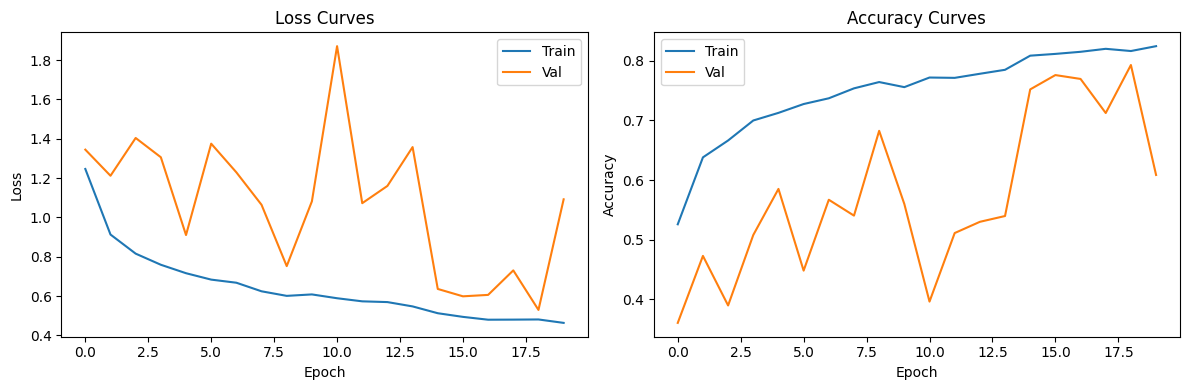

In [ ]:
# ============================================================
# 5. TRAINING LOOP
# ============================================================
best_val_acc = 0.0
best_model_path = "/content/illumicam3.pth"
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({"loss": loss.item(), "acc": correct/total})

    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

print("\n" + "="*60)
print("TRAINING")
print("="*60)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> Saved best model (val_acc: {val_acc:.4f})")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history["train_loss"], label="Train")
ax1.plot(history["val_loss"], label="Val")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Curves")
ax1.legend()

ax2.plot(history["train_acc"], label="Train")
ax2.plot(history["val_acc"], label="Val")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy Curves")
ax2.legend()

plt.tight_layout()
plt.savefig("/content/training_curves.png", dpi=150)
plt.show()


TEST SET EVALUATION


Testing: 100%|██████████| 4/4 [06:44<00:00, 101.01s/it]



Classification Report:
              precision    recall  f1-score   support

        Cool       0.73      0.73      0.73       156
     Neutral       0.78      0.66      0.72       156
   Very_Cool       0.75      0.78      0.76       156
   Very_Warm       0.85      0.90      0.87       156
        Warm       0.78      0.82      0.80       156

    accuracy                           0.78       780
   macro avg       0.78      0.78      0.78       780
weighted avg       0.78      0.78      0.78       780



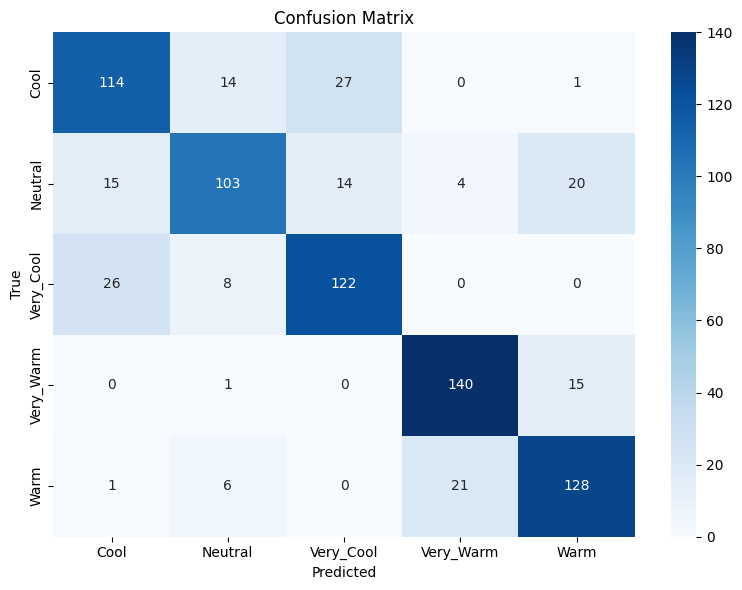


Test Accuracy: 0.7782


In [ ]:
# ============================================================
# 6. EVALUATION ON TEST SET
# ============================================================
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("/content/confusion_matrix.png", dpi=150)
plt.show()

test_acc = (all_preds == all_labels).mean()
print(f"\nTest Accuracy: {test_acc:.4f}")


GENERATING GRAD-CAM HEATMAPS
Saved 12 Grad-CAM visualizations to /content/gradcam_heatmaps


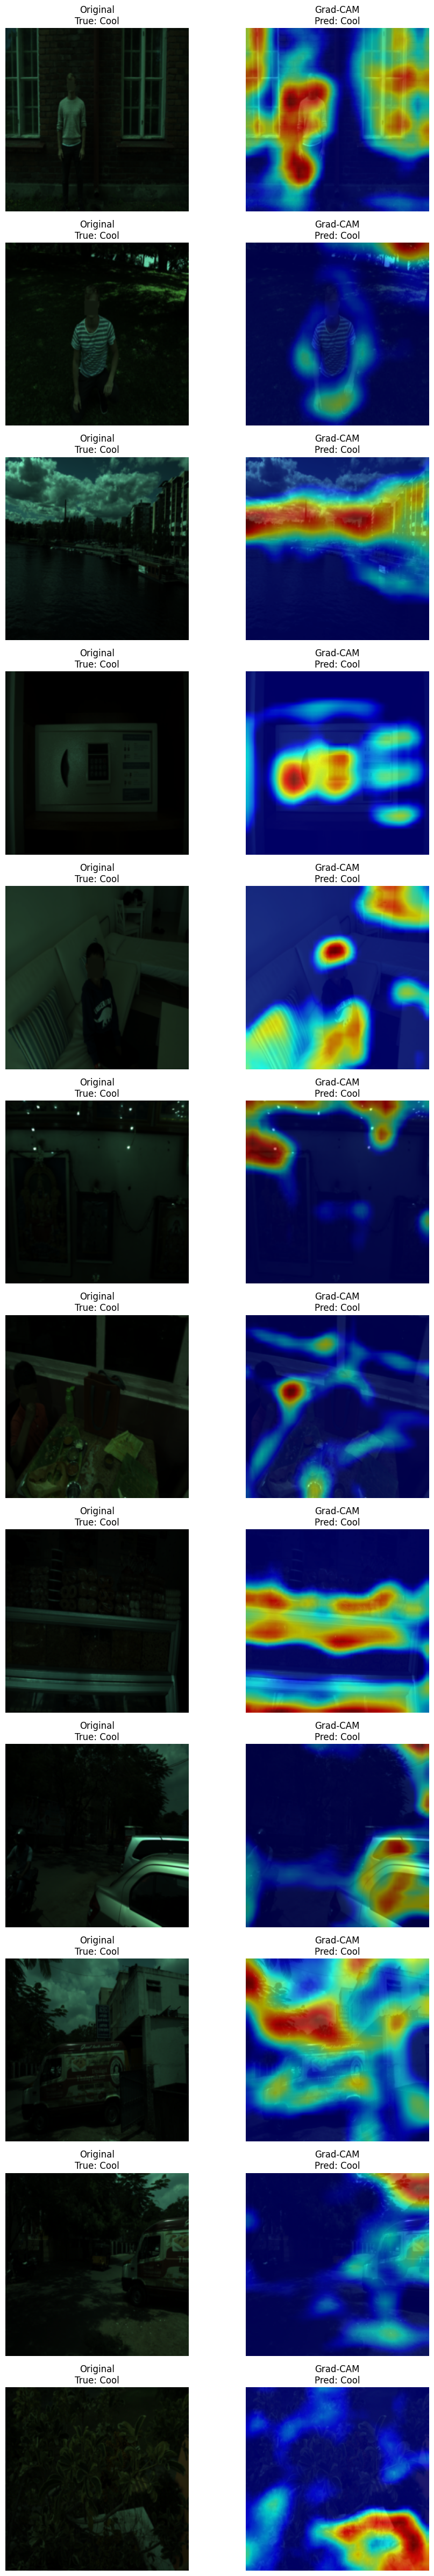


Done! Check /content/ for saved outputs.


In [ ]:
# ============================================================
# 7. GRAD-CAM HEATMAPS
# ============================================================
print("\n" + "="*60)
print("GENERATING GRAD-CAM HEATMAPS")
print("="*60)

def tensor_to_rgb(img_tensor, mean, std):
    """Convert normalized tensor to RGB [0,1] for visualization."""
    img_np = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0.0, 1.0)
    return img_np.astype(np.float32)

mean_np = np.array(mean, dtype=np.float32)
std_np = np.array(std, dtype=np.float32)

# Target layer: last conv layer
target_layers = [model.conv5]

cam = GradCAM(model=model, target_layers=target_layers)

save_dir = "/content/gradcam_heatmaps"
os.makedirs(save_dir, exist_ok=True)

num_examples_to_show = 12
examples = []
processed = 0

model.eval()

# Create a new loader with num_workers=0 to avoid multiprocessing issues in Colab
gradcam_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

for images, labels in gradcam_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct_mask = preds == labels

    for i in range(images.size(0)):
        if not correct_mask[i]:
            continue

        if processed >= num_examples_to_show:
            break

        input_tensor = images[i].unsqueeze(0)
        true_label = int(labels[i].item())
        pred_label = int(preds[i].item())

        targets = [ClassifierOutputTarget(pred_label)]

        # Grad-CAM needs gradients enabled
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        rgb_image = tensor_to_rgb(input_tensor[0], mean_np, std_np)
        overlay = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

        true_name = label_names[true_label]
        pred_name = label_names[pred_label]

        # Save images
        base_name = f"idx_{processed:03d}_{true_name}"
        Image.fromarray((rgb_image * 255).astype(np.uint8)).save(
            os.path.join(save_dir, f"{base_name}_orig.png")
        )
        Image.fromarray(overlay).save(
            os.path.join(save_dir, f"{base_name}_gradcam.png")
        )

        examples.append((rgb_image, overlay, true_name, pred_name))
        processed += 1

    if processed >= num_examples_to_show:
        break

print(f"Saved {processed} Grad-CAM visualizations to {save_dir}")

# Plot grid
rows = len(examples)
if rows > 0:
    fig, axes = plt.subplots(rows, 2, figsize=(10, 4 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for idx, (rgb_image, overlay, true_name, pred_name) in enumerate(examples):
        axes[idx, 0].imshow(rgb_image)
        axes[idx, 0].set_title(f"Original\nTrue: {true_name}")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(overlay)
        axes[idx, 1].set_title(f"Grad-CAM\nPred: {pred_name}")
        axes[idx, 1].axis("off")

    plt.tight_layout()
    plt.savefig("/content/gradcam_grid.png", dpi=150, bbox_inches='tight')
    plt.show()

print("\nDone! Check /content/ for saved outputs.")